# TM10007 Machine Learning Group 10 Liver 

 Casper Koorenhof (5118921), Tara Vijgeboom (5009677), Anouk de Vreede (5059313), Lianne ter Wisscha (5557135)

In [109]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Importing packages 


In [110]:
# === General packages ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import random
from collections import defaultdict
from sklearn.utils import shuffle

# === Scikit-learn: data handling and preprocessing ===
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# === Feature selection ===
from sklearn.feature_selection import (
    SelectKBest, f_classif, mutual_info_classif,
    VarianceThreshold
)

# === Classifiers ===
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# === Model evaluation and validation ===
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, learning_curve
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc 
from sklearn.base import clone

## Data loading 

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!


In [111]:
from worcliver.load_data import load_data

# Load the data
data = load_data()

# Replace the labels with binary labels
data_binary = data.copy()
data_binary["label"] = data_binary["label"].map({"malignant": 1, "benign": 0})

# Print number of samples and columns
print(f"The number of samples: {len(data_binary.index)}")
print(f"The number of columns: {len(data_binary.columns)}")
print(f"The number of malignant samples: {sum(data_binary['label']==1)}")
print(f"The number of benign samples: {sum(data_binary['label']==0)}")

The number of samples: 186
The number of columns: 494
The number of malignant samples: 94
The number of benign samples: 92


## Data preprocessing

Checking whether the data contains duplicate samples and/or features. If so, the duplicate is dropped from the data set. Moreover, the amount of infinite and missing data is determined.

In [ ]:
# Checking for duplicate features
duplicate_features = data_binary.columns[data_binary.columns.duplicated()]
if len(duplicate_features) > 0:
    print(f"Number of duplicate features: {len(duplicate_features)}")
    print("Duplicate feature names:")
    print(list(duplicate_features))
    # Remove duplicate features
    data_cleaned = data_binary.loc[:, ~data_binary.columns.duplicated()]   
else:
    data_cleaned = data_binary.copy()
    print("No duplicate features found.")

# Checking for missing data
# Check for infinite values
print(f"Amount of infinite data: {data_cleaned.map(np.isinf).sum().sum()}")
# Check for missing values
print(f"Amount of missing data: {data_cleaned.isna().sum().sum()}")


No duplicate features found.
Amount of infinite data: 0
Amount of missing data: 0


## Data splitting


By performing crossvalidation the data is split in 80% train and 20% test data in the outer crossvalidation step and again in 80% train and 20% validation data in the inner crossvalidation step.

In [113]:
# Set the random state globally for reproducibility
np.random.seed(42)  # numpy random seed for general operations
random.seed(42)  # Python's random module seed
shuffle.random_state = 42  # to control shuffling behavior in sklearn

# Split the dataset in features and labels
X = data_cleaned.drop(columns=["label"])
y = data_cleaned["label"]

# Split the dataset in train, validation and test part
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Random state is set to 42 for reproducibility
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Selection of first fold to determine scaling and feature selection


The first fold of the outer crossvalidation is used to determine the scaling method of the data and for further feature selection. 

In this section it is tested whether the data is normally distributed or not by performing the Shapiro-Wilk test:
- p-value > alpha (0.05): the data is likely normally distributed.
  - In this case missing data (NaN) is replaced by the mean of the feature data.
- p-value < alpha (0.05): the data is likely not normally distributed.
  - In this case missing data (NaN) is replaced by the median of the feature data.

In [114]:
# Selecting the first fold of the outer cross-validation
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    if i == 0:
        X_train_fold1 = X.iloc[train_idx].copy()
        y_train_fold1 = y.iloc[train_idx].copy()
        X_test_fold1 = X.iloc[test_idx].copy()
        y_test_fold1 = y.iloc[test_idx].copy()
    else:
        break

# === Normality check + imputatie ===
alpha = 0.05
nd_columns_train = 0
nnd_columns_train = 0

for column in X_train_fold1.columns:
    if X_train_fold1[column].min() != X_train_fold1[column].max(): # Check if the column is not constant
        stat, p = shapiro(X_train_fold1[column].dropna()) # Perform Shapiro-Wilk test for normality
        if p > alpha:
            nd_columns_train += 1
            if X_train_fold1[column].isna().sum() > 0:
                X_train_fold1[column].fillna(X_train_fold1[column].mean(), inplace=True)
        else:
            nnd_columns_train += 1
            if X_train_fold1[column].isna().sum() > 0:
                X_train_fold1[column].fillna(X_train_fold1[column].median(), inplace=True)

print(f"Normal distributed columns: {nd_columns_train}")
print(f"Non-normal distributed columns: {nnd_columns_train}")

Normal distributed columns: 56
Non-normal distributed columns: 420


For scaling the data, the interquartile range (IQR) is computed on each feature in the train data. Any value below or above the set thresholds, is considered an outlier. The count of features with more than 5% of their values considered as outliers, gives an idea of how widespread this issue of outliers is.

**RobustScaler**
- Is more robust to outliers
- Ensures that the scaled data is not disproportionately affected by outliers

In [115]:
# === Outlier analyse ===
columns_many_outliers_count = 0
for column in X_train_fold1.columns:
    Q1 = X_train_fold1[column].quantile(0.25)
    Q3 = X_train_fold1[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = X_train_fold1[(X_train_fold1[column] < (Q1 - 1.5 * IQR)) | (X_train_fold1[column] > (Q3 + 1.5 * IQR))]
    if outliers.shape[0] > 0.05 * X_train_fold1.shape[0]:
        columns_many_outliers_count += 1

perc_columns_many_outliers = (columns_many_outliers_count / len(X_train_fold1.columns)) * 100
print(f"Columns with 5% outliers: {columns_many_outliers_count}/{len(X_train_fold1.columns)} = {perc_columns_many_outliers:.2f}%")

# === Scaling ===
scaler = RobustScaler()
X_train_1sc = pd.DataFrame(scaler.fit_transform(X_train_fold1), columns=X_train_fold1.columns, index=X_train_fold1.index)
X_test_1sc = pd.DataFrame(scaler.transform(X_test_fold1), columns=X_test_fold1.columns, index=X_test_fold1.index)


Columns with 5% outliers: 156/493 = 31.64%


### Visualizing data before and after scaling

Visualizing the effect of applying the RobustScaler on the first 10 features of the train data. This is used for interpretation and verifying purposes only.

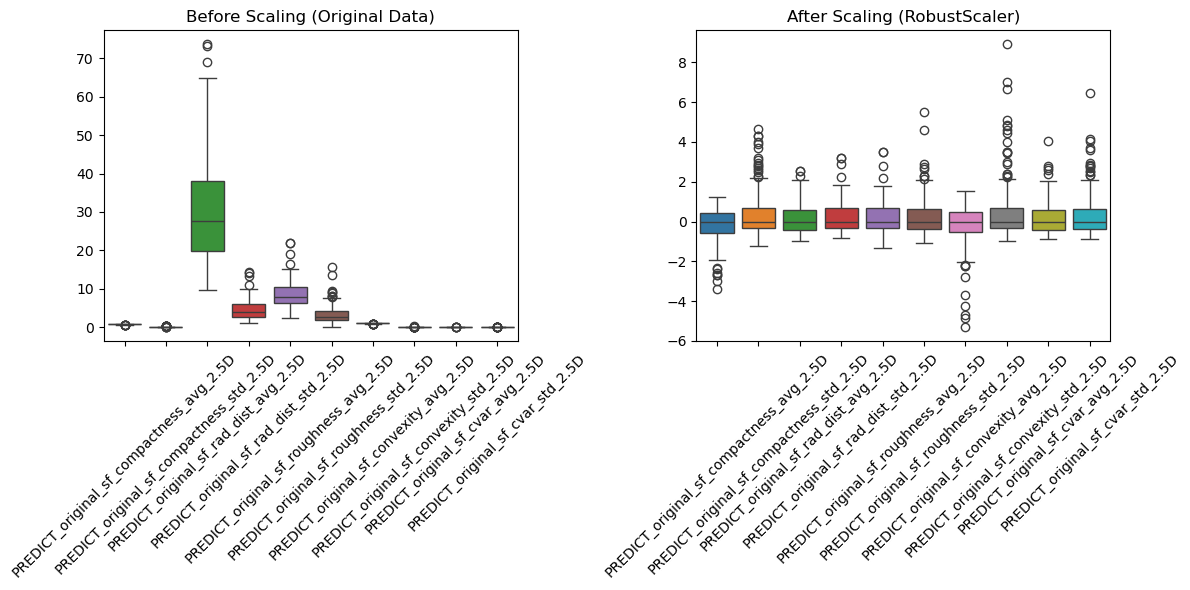

In [116]:
# Select first 10 features for visualization
features_to_plot = X_train_fold1.columns[:10] 
# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# Plot original (unscaled) data
plt.subplot(1, 2, 1)
sns.boxplot(data=X_train_fold1[features_to_plot])
plt.title("Before Scaling (Original Data)")
plt.xticks(rotation=45)

# Plot scaled data
plt.subplot(1, 2, 2)
sns.boxplot(data=X_train_1sc[features_to_plot])
plt.title("After Scaling (RobustScaler)")
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

## Feature Selection
https://scikit-learn.org/stable/modules/feature_selection.html

### 1. Removing data with low variance
The data set is refined by selecting only features that are likely to contribute useful information to the model.
- A threshold of 0.05 is used, meaning a feature must vary enough to be kept.

In [117]:
# Keep only numeric columns 
X_train_1sc = X_train_1sc.select_dtypes(include=[np.number])
X_test_1sc = X_test_1sc.select_dtypes(include=[np.number])

# Only apply VarianceThreshold if any features have low variance
zv_selector = VarianceThreshold(threshold=0.05)
zv_selector.fit(X_train_1sc)

support_mask = zv_selector.get_support()
n_removed = len(support_mask) - sum(support_mask)

if n_removed > 0:
    X_train_1sc = pd.DataFrame(zv_selector.transform(X_train_1sc), columns=X_train_1sc.columns[support_mask])
    X_test_1sc = pd.DataFrame(zv_selector.transform(X_test_1sc), columns=X_test_1sc.columns[support_mask])
    print(f"Number of features removed due to low variance: {n_removed}")
else:
    print("No features with low variance found — skipping removal.")


Number of features removed due to low variance: 32


### 2. Feature selection basic classifiers
In this section different feature selection methods are compared and their impact on the performance of basic classifiers is evaluated. 

**Feature selection techniques:**
- PCA, SelectKBest (F-score and Mutual Information), LASSO

**Classifiers:**
- LDA, QDA, LR

For each combination of feature selection method and classifier:
- The data is reduced to the top-k features
- The classifier is trained on the training set and tested on the test set
- Accuracy is recorded as the performance metric

Bar plots are created to compare the accuracy scores across different models and feature selection methods for each k values. 

c:\Users\liann\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\liann\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

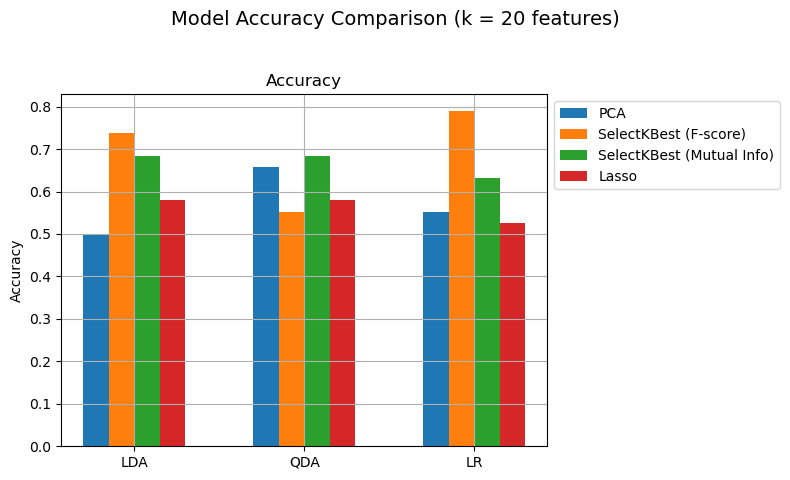

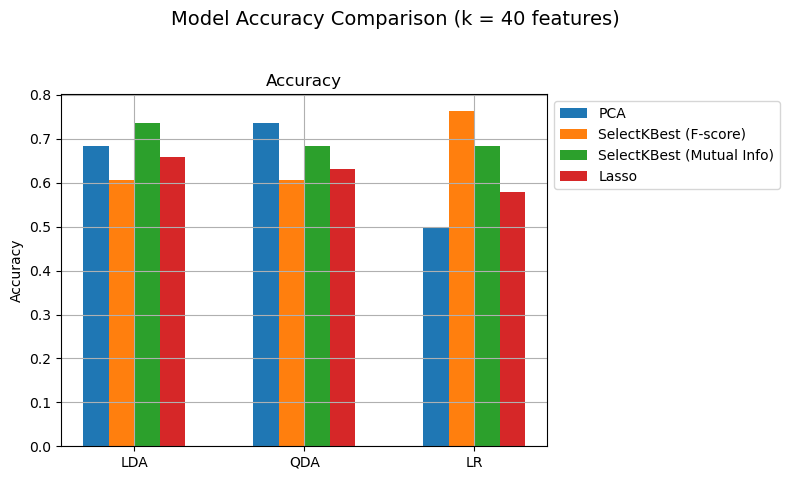

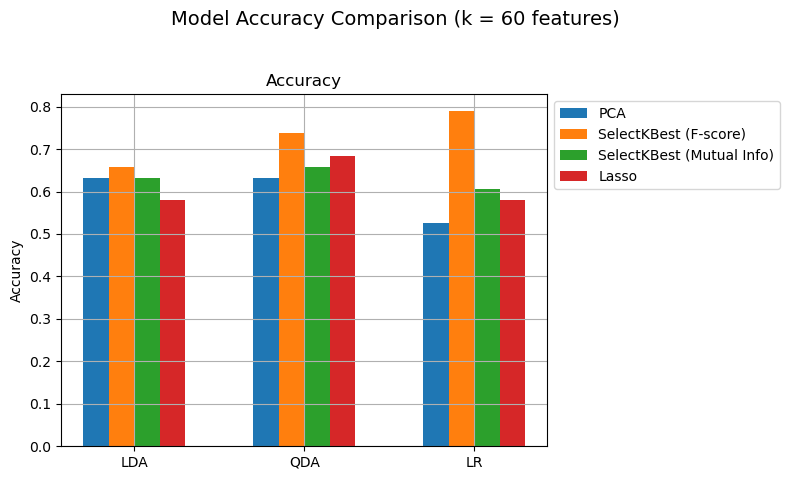

In [118]:
# Function to compare different feature selection methods
def feature_selection_method_comparison(models, k_values, X_train, X_test, y_train, y_test):
    """
    This function compares multiple feature selection methods(PCA, SelectKBest (F-Score), SelectKBest (Mutual Information), 
    and Lasso) on a given set of models for each value of k. Accuracies are visualized in a plot.

    Parameters:
    models : dict
        A dictionary of model names and instantiated scikit-learn classifiers (e.g., {"SVM": SVC(), "RF": RandomForestClassifier()}).

    k_values : list of int
        List of feature counts (k) to use in the feature selection methods.

    X_train : pd.DataFrame or np.ndarray
        The training feature matrix.

    X_test : pd.DataFrame or np.ndarray
        The test feature matrix.

    y_train : pd.Series or np.ndarray
        The training labels.

    y_test : pd.Series or np.ndarray
        The test labels.

    Returns:
    -------
    plt : matplotlib.pyplot
    """

    # Store results
    results = {
        k: {
            method: {model: {} for model in models}
            for method in ["PCA", "SelectKBest (F-Score)", "SelectKBest (Mutual Info)", "Lasso"]
        }
        for k in k_values
    }

    for k in k_values: 
        for method_name in results[k]:
            for model_name, model in models.items():           
                if method_name == "PCA":
                    reducer = PCA(n_components=k, random_state=42)
                    X_train_reduced = reducer.fit_transform(X_train)
                    X_test_reduced = reducer.transform(X_test)

                elif method_name == "SelectKBest (F-Score)":
                    reducer = SelectKBest(f_classif, k=k)
                    X_train_reduced = reducer.fit_transform(X_train, y_train)
                    X_test_reduced = reducer.transform(X_test)

                elif method_name == "SelectKBest (Mutual Info)":
                    reducer = SelectKBest(mutual_info_classif, k=k)
                    X_train_reduced = reducer.fit_transform(X_train, y_train)
                    X_test_reduced = reducer.transform(X_test)

                elif method_name == "Lasso":
                    lasso = Lasso(random_state=42)
                    lasso.fit(X_train, y_train)
                    coef = np.abs(lasso.coef_)
                    top_indices = np.argsort(coef)[-k:]
                    X_train_reduced = X_train.iloc[:, top_indices]
                    X_test_reduced = X_test.iloc[:, top_indices]

                # Train and evaluate
                model_clone = clone(model)
                model_clone.fit(X_train_reduced, y_train)
                y_pred = model_clone.predict(X_test_reduced)

                acc = accuracy_score(y_test, y_pred)

                results[k][method_name][model_name] = {
                    "accuracy": acc
                }

    # === Plot comparison (only accuracy) ===
    for k in k_values:
        fig, ax = plt.subplots(figsize=(8, 5))
        fig.suptitle(f'Model Accuracy Comparison (k = {k} features)', fontsize=14)

        labels = list(models.keys())
        x = np.arange(len(labels))
        width = 0.15

        pca_scores = [results[k]["PCA"].get(label, {}).get("accuracy", np.nan) for label in labels]
        skb_scores = [results[k]["SelectKBest (F-Score)"].get(label, {}).get("accuracy", np.nan) for label in labels]
        mi_scores = [results[k]["SelectKBest (Mutual Info)"].get(label, {}).get("accuracy", np.nan) for label in labels]
        lasso_scores = [results[k]["Lasso"].get(label, {}).get("accuracy", np.nan) for label in labels]

        ax.bar(x - 1.5 * width, pca_scores, width, label='PCA')
        ax.bar(x - 0.5 * width, skb_scores, width, label='SelectKBest (F-score)')
        ax.bar(x + 0.5 * width, mi_scores, width, label='SelectKBest (Mutual Info)')
        ax.bar(x + 1.5 * width, lasso_scores, width, label='Lasso')

        ax.set_ylabel("Accuracy")
        ax.set_title("Accuracy")
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.grid(True)
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    return plt

# Basic models to test
models = {
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(reg_param=0.001),
    "LR": LogisticRegression(random_state=42),
}

# List of number of features to compare the different feature selection methods on
k_values = [20, 40, 60]

# Compare feature selection methods on the basic models on the first outer fold (fold 1)
feature_selection_basic_models = feature_selection_method_comparison(models, k_values, X_train_1sc, X_test_1sc, y_train_fold1, y_test_fold1)

### 3. Feature selection complex classifiers
In this section different feature selection methods are compared and their impact on the performance of complex classifiers is evaluated. 

**Feature selection techniques:**
- PCA, SelectKBest (F-score and Mutual Information), LASSO

**Classifiers:**
- kNN, SVM, RFC

For each combination of feature selection method and classifier:
- The data is reduced to the top-k features
- The classifier is trained on the training set and tested on the test set
- Accuracy is recorded as the performance metric

Bar plots are created to compare the accuracy scores across different models and feature selection methods for each k values. 

c:\Users\liann\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.692e+01, tolerance: 3.699e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\liann\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.692e+01, tolerance: 3.699e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\liann\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.692e+01, toler

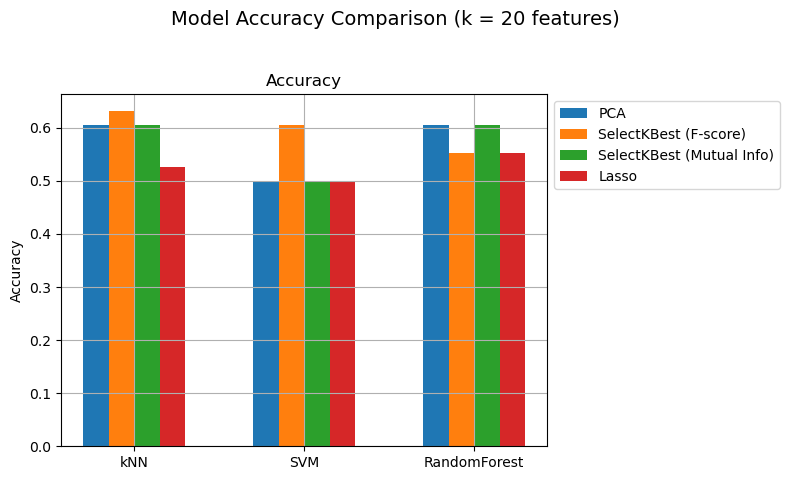

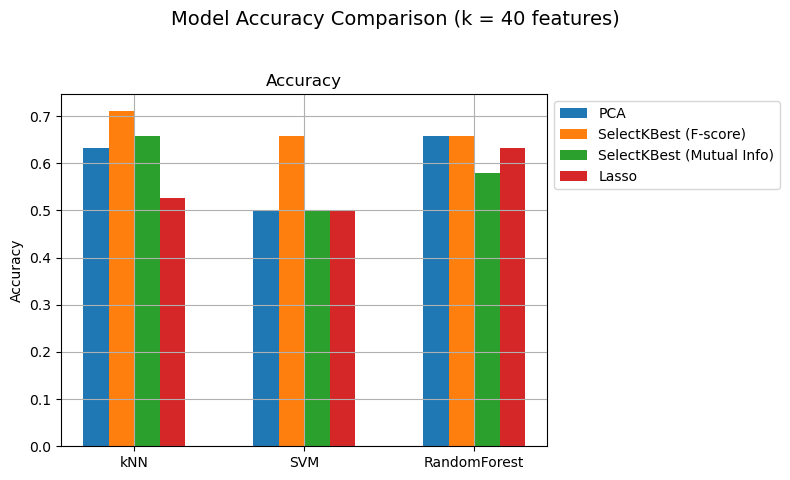

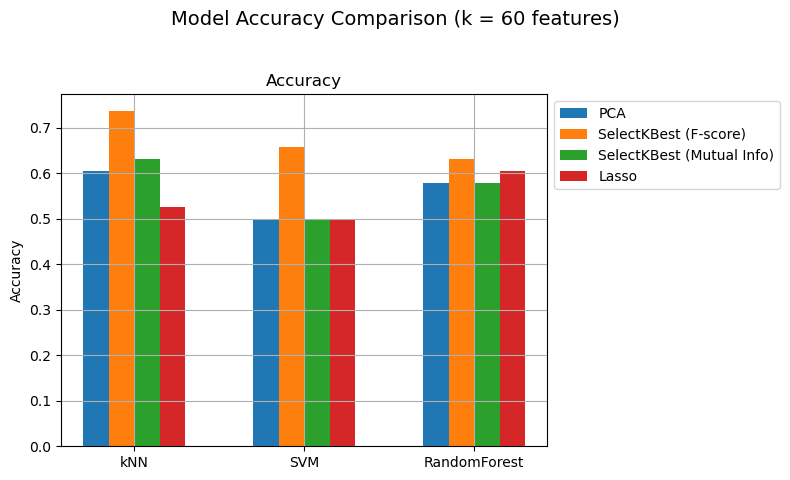

In [119]:
# Complex models to test
models = {
    "kNN": KNeighborsClassifier(),
    "SVM": SVC(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42)
}

# List of number features to compare the different feature selection methods on
k_values = [20, 40, 60]

# Compare feature selection methods on the complex models based on the first outer fold (fold 1)
feature_selection_complex_models = feature_selection_method_comparison(models, k_values, X_train_1sc, X_test_1sc, y_train_fold1, y_test_fold1)

## Hyperparameter tuning 
### Basic classifiers
Here, each model is evaluated across 5 folds using a combination of feature selection and hyperparameter tuning.

*For each fold the following are recorded:*
- Training and test accuracy
- Training and test ROC AUC
- Best hyperparameters
- Interpolated TPR values for generating a smooth average ROC curve

In [120]:
X_full = X
y_full = y

# Basic models and their grids
models_basic = {
    'LDA': {
        'pipeline': Pipeline([
            ('variance_filter', VarianceThreshold(threshold=0.05)),
            ('scaler', RobustScaler()),
            ('select', PCA(random_state=42)),
            ('clf', LinearDiscriminantAnalysis())
        ]),
        'param_grid': {
            'select__n_components': range(1, 61), # Number of components for PCA
            'clf__solver': ['lsqr', 'eigen'], # Solver for LDA
            'clf__shrinkage': [None, 'auto'] + list(np.linspace(0, 1, 5)), # Shrinkage parameter for LDA
            'clf__priors': [None, [0.5, 0.5]] # Class priors for LDA
        }
    },
    'QDA': {
        'pipeline': Pipeline([
            ('variance_filter', VarianceThreshold(threshold=0.05)),
            ('scaler', RobustScaler()),
            ('select', SelectKBest(score_func=f_classif)),
            ('clf', QuadraticDiscriminantAnalysis())
        ]),
        'param_grid': {
            'select__k': range(1, 61), # Number of features to select
            'clf__reg_param': [0.2, 0.4, 0.6, 0.8, 1.0], # Regularization parameter for QDA
            'clf__priors': [None, [0.5, 0.5]], # Class priors for QDA
            'clf__store_covariance': [True, False], # Whether to store covariance matrix for QDA
            'clf__tol': [1e-4, 1e-3, 1e-2] # Tolerance for convergence in QDA
        }
    },
    'Logistic Regression': {
        'pipeline': Pipeline([
            ('variance_filter', VarianceThreshold(threshold=0.05)),
            ('scaler', RobustScaler()),
            ('select', SelectKBest(score_func=f_classif)),
            ('clf', LogisticRegression(random_state=42))
        ]),
        'param_grid': {
            'select__k': range(1, 61), # Number of features to select
            'clf__C': [0.001, 0.01, 0.1, 1.0, 10, 100], # Inverse of regularization strength for Logistic Regression
            'clf__penalty': ['l1', 'l2'], # Regularization type for Logistic Regression
            'clf__solver': ['liblinear', 'saga'], # Solver for Logistic Regression
            'clf__max_iter': [500, 1000, 1500, 2000] # Maximum number of iterations for convergence in Logistic Regression
        }
    }
}

results_per_fold_basic = defaultdict(list)
roc_data_basic = {}

# Loop through models 
for idx, (name, config) in enumerate(models_basic.items()):
    print(f"\n=== Outer CV for {name} ===")

    train_accuracy_scores = []
    train_auc_scores = []
    accuracy_scores = []
    roc_auc_scores = []
    best_params_list = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_full, y_full), start=1):
        X_outer_train = X_full.iloc[train_idx]
        y_outer_train = y_full.iloc[train_idx]
        X_outer_test = X_full.iloc[test_idx]
        y_outer_test = y_full.iloc[test_idx]

        grid = RandomizedSearchCV(
            config['pipeline'], config['param_grid'], n_iter=50, cv=inner_cv,
            scoring='accuracy', n_jobs=-1, random_state=42, return_train_score=True
        )
        grid.fit(X_outer_train, y_outer_train)

        print(f"\n=== Outer Fold {fold} ===")
        print("Best hyperparameters:", grid.best_params_)

        print(f"\nTop 5 results from inner CV (validation) for fold {fold}:")
        sorted_idx = np.argsort(grid.cv_results_['rank_test_score'])[:5]
        for i in sorted_idx:
            params = grid.cv_results_['params'][i]
            mean_score = grid.cv_results_['mean_test_score'][i]
            std_score = grid.cv_results_['std_test_score'][i]
            print(f"Score: {mean_score:.4f} ± {std_score:.4f} | Params: {params}")

        best_model = grid.best_estimator_
        best_params_list.append(grid.best_params_)

        y_train_pred = best_model.predict(X_outer_train)
        y_train_proba = best_model.predict_proba(X_outer_train)[:, 1]
        y_test_pred = best_model.predict(X_outer_test)
        y_test_proba = best_model.predict_proba(X_outer_test)[:, 1]

        train_acc = accuracy_score(y_outer_train, y_train_pred)
        train_auc = roc_auc_score(y_outer_train, y_train_proba)
        test_acc = accuracy_score(y_outer_test, y_test_pred)
        test_auc = roc_auc_score(y_outer_test, y_test_proba)

        train_accuracy_scores.append(train_acc)
        train_auc_scores.append(train_auc)
        accuracy_scores.append(test_acc)
        roc_auc_scores.append(test_auc)

        fpr, tpr, _ = roc_curve(y_outer_test, y_test_proba)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        fold_auc = auc(fpr, tpr)
        aucs.append(fold_auc)
 
        y_train_pred = best_model.predict(X_outer_train)
        y_train_proba = best_model.predict_proba(X_outer_train)[:, 1]
        y_test_pred = best_model.predict(X_outer_test)
        y_test_proba = best_model.predict_proba(X_outer_test)[:, 1]

        train_acc = accuracy_score(y_outer_train, y_train_pred)
        train_auc = roc_auc_score(y_outer_train, y_train_proba)
        test_acc = accuracy_score(y_outer_test, y_test_pred)
        test_auc = roc_auc_score(y_outer_test, y_test_proba)

        train_accuracy_scores.append(train_acc)
        train_auc_scores.append(train_auc)
        accuracy_scores.append(test_acc)
        roc_auc_scores.append(test_auc)

        results_per_fold_basic[name].append({
            'fold': fold,
            'train accuracy': train_acc,
            'train ROC AUC': train_auc,
            'test accuracy': test_acc,
            'test ROC AUC': test_auc,
            'y_true': y_outer_test,
            'y_pred_proba': y_test_proba
        })

        models_basic[name]["best_params"] = best_params_list

    print("\n=== Summary ===")
    print("Best estimators per fold:")
    for i, params in enumerate(best_params_list, 1):
        print(f"Fold {i}: {params}")


=== Outer CV for LDA ===

=== Outer Fold 1 ===
Best hyperparameters: {'select__n_components': 50, 'clf__solver': 'lsqr', 'clf__shrinkage': None, 'clf__priors': None}

Top 5 results from inner CV (validation) for fold 1:
Score: 0.7430 ± 0.0594 | Params: {'select__n_components': 50, 'clf__solver': 'lsqr', 'clf__shrinkage': None, 'clf__priors': None}
Score: 0.7228 ± 0.0659 | Params: {'select__n_components': 48, 'clf__solver': 'lsqr', 'clf__shrinkage': None, 'clf__priors': [0.5, 0.5]}
Score: 0.7156 ± 0.0831 | Params: {'select__n_components': 60, 'clf__solver': 'eigen', 'clf__shrinkage': 'auto', 'clf__priors': None}
Score: 0.7021 ± 0.0488 | Params: {'select__n_components': 25, 'clf__solver': 'eigen', 'clf__shrinkage': np.float64(0.0), 'clf__priors': [0.5, 0.5]}
Score: 0.6961 ± 0.0417 | Params: {'select__n_components': 40, 'clf__solver': 'eigen', 'clf__shrinkage': np.float64(0.0), 'clf__priors': None}

=== Outer Fold 2 ===
Best hyperparameters: {'select__n_components': 59, 'clf__solver': 'l

### Results outer folds basic classifiers


=== Results per fold for LDA ===
Fold 1:
Train Accuracy: 0.8784
Train ROC AUC: 0.9602
Test Accuracy: 0.6316
Test ROC AUC: 0.7618

Fold 2:
Train Accuracy: 0.8993
Train ROC AUC: 0.9629
Test Accuracy: 0.6486
Test ROC AUC: 0.7164

Fold 3:
Train Accuracy: 0.8993
Train ROC AUC: 0.9486
Test Accuracy: 0.5946
Test ROC AUC: 0.7164

Fold 4:
Train Accuracy: 0.7987
Train ROC AUC: 0.8944
Test Accuracy: 0.6486
Test ROC AUC: 0.7281

Fold 5:
Train Accuracy: 0.9060
Train ROC AUC: 0.9580
Test Accuracy: 0.5946
Test ROC AUC: 0.7339

Overall Results for LDA:
Train Accuracy  (mean ± std): 0.8763 ± 0.0399
Train ROC AUC   (mean ± std): 0.9448 ± 0.0257
Test  Accuracy  (mean ± std): 0.6236 ± 0.0245
Test  ROC AUC   (mean ± std): 0.7313 ± 0.0167

=== Results per fold for QDA ===
Fold 1:
Train Accuracy: 0.7838
Train ROC AUC: 0.8899
Test Accuracy: 0.6579
Test ROC AUC: 0.8449

Fold 2:
Train Accuracy: 0.7785
Train ROC AUC: 0.9066
Test Accuracy: 0.6216
Test ROC AUC: 0.8158

Fold 3:
Train Accuracy: 0.8054
Train ROC AUC

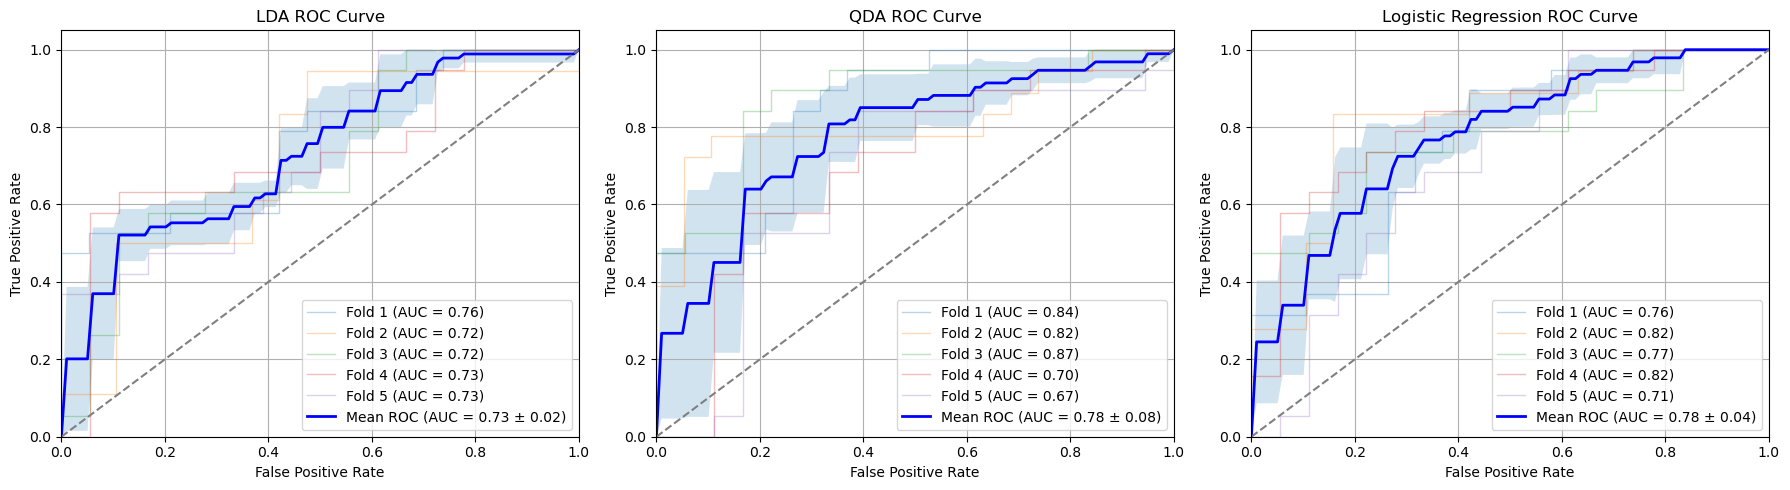

In [121]:
# Print the results for each basic classifier
for name in results_per_fold_basic:
    print(f"\n=== Results per fold for {name} ===")
    for fold_result in results_per_fold_basic[name]:
        # Print the results for each fold
        print(f"Fold {fold_result['fold']}:")
        print(f"Train Accuracy: {fold_result['train accuracy']:.4f}")
        print(f"Train ROC AUC: {fold_result['train ROC AUC']:.4f}")
        print(f"Test Accuracy: {fold_result['test accuracy']:.4f}")
        print(f"Test ROC AUC: {fold_result['test ROC AUC']:.4f}\n")
    
    train_accuracy_scores = [r['train accuracy'] for r in results_per_fold_basic[name]]
    train_auc_scores = [r['train ROC AUC'] for r in results_per_fold_basic[name]]
    accuracy_scores = [r['test accuracy'] for r in results_per_fold_basic[name]]
    roc_auc_scores = [r['test ROC AUC'] for r in results_per_fold_basic[name]]

    avg_train_accuracy = np.mean(train_accuracy_scores)
    std_train_accuracy = np.std(train_accuracy_scores)
    avg_train_auc = np.mean(train_auc_scores)
    std_train_auc = np.std(train_auc_scores)
    avg_test_accuracy = np.mean(accuracy_scores)
    std_test_accuracy = np.std(accuracy_scores)
    avg_test_auc = np.mean(roc_auc_scores)
    std_test_auc = np.std(roc_auc_scores)

    # Print the overall results for each basic classifier
    print(f"Overall Results for {name}:")
    print(f"Train Accuracy  (mean ± std): {avg_train_accuracy:.4f} ± {std_train_accuracy:.4f}")
    print(f"Train ROC AUC   (mean ± std): {avg_train_auc:.4f} ± {std_train_auc:.4f}")
    print(f"Test  Accuracy  (mean ± std): {avg_test_accuracy:.4f} ± {std_test_accuracy:.4f}")
    print(f"Test  ROC AUC   (mean ± std): {avg_test_auc:.4f} ± {std_test_auc:.4f}")

# Plot ROC curves for basic models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
mean_fpr = np.linspace(0, 1, 100)

# Loop through each basic model and plot ROC curves
for idx, (name, config) in enumerate(models_basic.items()):
    tprs = []
    aucs = []
    mean_tpr = np.zeros_like(mean_fpr)

    # Loop through each fold's results
    for fold_results in results_per_fold_basic[name]:
        fpr, tpr, _ = roc_curve(fold_results['y_true'], fold_results['y_pred_proba'])
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        fold_auc = auc(fpr, tpr)
        aucs.append(fold_auc)

        axes[idx].plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {fold_results["fold"]} (AUC = {fold_auc:.2f})')

    # Calculate mean and std of ROC curves
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    # Plot mean ROC curve
    axes[idx].plot(mean_fpr, mean_tpr, color='b',
                   label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    axes[idx].fill_between(mean_fpr,
                           np.maximum(mean_tpr - np.std(tprs, axis=0), 0),
                           np.minimum(mean_tpr + np.std(tprs, axis=0), 1), alpha=0.2)

    # Plot diagonal line
    axes[idx].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axes[idx].set_xlim([0.0, 1.0])
    axes[idx].set_ylim([0.0, 1.05])
    axes[idx].set_xlabel('False Positive Rate')
    axes[idx].set_ylabel('True Positive Rate')
    axes[idx].set_title(f'{name} ROC Curve')
    axes[idx].legend(loc='lower right')
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

### Complex classifiers 
Evaluation of three classifiers (kNN, SVM and RFC) using a 5-fold crossvalidation. Each model is wrapped in a pipeline that standerdizes preprocessing and feature selection and is paired with a tailored hyperparameter grid. 

*Metrics*: Accuracy and ROC AUC for both training and test sets
*Visualization*: Individual ROC curves per fold, mean ROC curve with +- 1 std. shading.

**Outputs:**
- Top 5 inner CV scores per outer fold
- Best parameters for each outer fold
- Mean +- std. for accuracy and ROC AUC
- ROC curve plots per model with fold-wise and averaged AUCs

In [122]:
X_full = X
y_full = y

# Complex models and their grids
models_complex = {
    "kNN": {
        "pipeline": Pipeline([
            ('variance_filter', VarianceThreshold(threshold=0.05)),
            ('scaler', RobustScaler()),
            ('select', SelectKBest(score_func=f_classif)),
            ('clf', KNeighborsClassifier())
        ]),
        "param_grid": {
            'select__k': list(range(1, 61)),
            'clf__n_neighbors': [1, 3, 5, 7, 9, 11],
            'clf__weights': ['uniform'],
            'clf__p': [1, 2] # 1 for Manhattan, 2 for Euclidean distance
        }
    },
    "SVM": {
        "pipeline": Pipeline([
            ('variance_filter', VarianceThreshold(threshold=0.05)),
            ('scaler', RobustScaler()),
            ('select', SelectKBest(score_func=f_classif)),
            ('clf', SVC(probability=True, random_state=42))
        ]),
        "param_grid": {
            'select__k': list(range(1, 61)),
            'clf__C': [0.1, 1, 10, 100],
            'clf__kernel': ['linear', 'rbf'],
            'clf__gamma': ['scale', 'auto', 0.01, 0.1, 1]
        }
    },
    "Random Forest": {
        "pipeline": Pipeline([
            ('variance_filter', VarianceThreshold(threshold=0.05)),
            ('scaler', RobustScaler()),
            ('clf', RandomForestClassifier(random_state=42))
        ]),
        "param_grid": {
            'clf__n_estimators': [50, 100, 150, 200],
            'clf__max_depth': [5, 10, 15, 20],
            'clf__min_samples_split': [2, 5, 10],
            'clf__min_samples_leaf': [4, 6, 8],
            'clf__max_features': ['sqrt', 'log2'],
            'clf__bootstrap': [True, False],
            'clf__min_impurity_decrease': [0.00001, 0.00005, 0.0001, 0.001]
        }
    }
}

results_per_fold_complex = defaultdict(list)
roc_data_complex = {}

# Loop through models 
for idx, (name, config) in enumerate(models_complex.items()):
    print(f"\n=== Outer CV for {name} ===")

    train_accuracy_scores = []
    train_auc_scores = []
    accuracy_scores = []
    roc_auc_scores = []
    best_params_list = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_full, y_full), start=1):
        X_outer_train = X_full.iloc[train_idx]
        y_outer_train = y_full.iloc[train_idx]
        X_outer_test = X_full.iloc[test_idx]
        y_outer_test = y_full.iloc[test_idx]

        grid = RandomizedSearchCV(
            config['pipeline'], config['param_grid'], n_iter=50, cv=inner_cv,
            scoring='accuracy', n_jobs=-1, random_state=42, return_train_score=True
        )
        grid.fit(X_outer_train, y_outer_train)

        print(f"\n=== Outer Fold {fold} ===")
        print("Best hyperparameters:", grid.best_params_)

        print(f"\nTop 5 results from inner CV (validation) for fold {fold}:")
        sorted_idx = np.argsort(grid.cv_results_['rank_test_score'])[:5]
        for i in sorted_idx:
            params = grid.cv_results_['params'][i]
            mean_score = grid.cv_results_['mean_test_score'][i]
            std_score = grid.cv_results_['std_test_score'][i]
            print(f"Score: {mean_score:.4f} ± {std_score:.4f} | Params: {params}")

        best_model = grid.best_estimator_
        best_params_list.append(grid.best_params_)

        y_train_pred = best_model.predict(X_outer_train)
        y_train_proba = best_model.predict_proba(X_outer_train)[:, 1]
        y_test_pred = best_model.predict(X_outer_test)
        y_test_proba = best_model.predict_proba(X_outer_test)[:, 1]

        train_acc = accuracy_score(y_outer_train, y_train_pred)
        train_auc = roc_auc_score(y_outer_train, y_train_proba)
        test_acc = accuracy_score(y_outer_test, y_test_pred)
        test_auc = roc_auc_score(y_outer_test, y_test_proba)

        train_accuracy_scores.append(train_acc)
        train_auc_scores.append(train_auc)
        accuracy_scores.append(test_acc)
        roc_auc_scores.append(test_auc)

        fpr, tpr, _ = roc_curve(y_outer_test, y_test_proba)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        fold_auc = auc(fpr, tpr)
        aucs.append(fold_auc)
 
        y_train_pred = best_model.predict(X_outer_train)
        y_train_proba = best_model.predict_proba(X_outer_train)[:, 1]
        y_test_pred = best_model.predict(X_outer_test)
        y_test_proba = best_model.predict_proba(X_outer_test)[:, 1]

        train_acc = accuracy_score(y_outer_train, y_train_pred)
        train_auc = roc_auc_score(y_outer_train, y_train_proba)
        test_acc = accuracy_score(y_outer_test, y_test_pred)
        test_auc = roc_auc_score(y_outer_test, y_test_proba)

        train_accuracy_scores.append(train_acc)
        train_auc_scores.append(train_auc)
        accuracy_scores.append(test_acc)
        roc_auc_scores.append(test_auc)

        results_per_fold_complex[name].append({
            'fold': fold,
            'train accuracy': train_acc,
            'train ROC AUC': train_auc,
            'test accuracy': test_acc,
            'test ROC AUC': test_auc,
            'y_true': y_outer_test,
            'y_pred_proba': y_test_proba
        })

        models_complex[name]["best_params"] = best_params_list

    print("\n=== Summary ===")
    print("Best estimators per fold:")
    for i, params in enumerate(best_params_list, 1):
        print(f"Fold {i}: {params}")


=== Outer CV for kNN ===

=== Outer Fold 1 ===
Best hyperparameters: {'select__k': 16, 'clf__weights': 'uniform', 'clf__p': 1, 'clf__n_neighbors': 3}

Top 5 results from inner CV (validation) for fold 1:
Score: 0.6961 ± 0.0467 | Params: {'select__k': 16, 'clf__weights': 'uniform', 'clf__p': 1, 'clf__n_neighbors': 3}
Score: 0.6821 ± 0.0479 | Params: {'select__k': 11, 'clf__weights': 'uniform', 'clf__p': 2, 'clf__n_neighbors': 7}
Score: 0.6756 ± 0.0500 | Params: {'select__k': 19, 'clf__weights': 'uniform', 'clf__p': 2, 'clf__n_neighbors': 3}
Score: 0.6752 ± 0.0386 | Params: {'select__k': 14, 'clf__weights': 'uniform', 'clf__p': 1, 'clf__n_neighbors': 3}
Score: 0.6747 ± 0.0674 | Params: {'select__k': 15, 'clf__weights': 'uniform', 'clf__p': 1, 'clf__n_neighbors': 5}

=== Outer Fold 2 ===
Best hyperparameters: {'select__k': 4, 'clf__weights': 'uniform', 'clf__p': 2, 'clf__n_neighbors': 1}

Top 5 results from inner CV (validation) for fold 2:
Score: 0.7320 ± 0.0748 | Params: {'select__k': 

### Results outer folds complex classifiers


=== Results per fold for kNN ===
Fold 1:
Train Accuracy: 0.8514
Train ROC AUC: 0.9182
Test Accuracy: 0.6316
Test ROC AUC: 0.7022

Fold 2:
Train Accuracy: 1.0000
Train ROC AUC: 1.0000
Test Accuracy: 0.7297
Test ROC AUC: 0.7339

Fold 3:
Train Accuracy: 0.7517
Train ROC AUC: 0.8351
Test Accuracy: 0.7297
Test ROC AUC: 0.7661

Fold 4:
Train Accuracy: 0.7584
Train ROC AUC: 0.8549
Test Accuracy: 0.7027
Test ROC AUC: 0.7851

Fold 5:
Train Accuracy: 0.7852
Train ROC AUC: 0.8747
Test Accuracy: 0.6486
Test ROC AUC: 0.6944

Overall Results for kNN:
Train Accuracy  (mean ± std): 0.8293 ± 0.0923
Train ROC AUC   (mean ± std): 0.8966 ± 0.0586
Test  Accuracy  (mean ± std): 0.6885 ± 0.0411
Test  ROC AUC   (mean ± std): 0.7363 ± 0.0352

=== Results per fold for SVM ===
Fold 1:
Train Accuracy: 0.8108
Train ROC AUC: 0.9123
Test Accuracy: 0.7368
Test ROC AUC: 0.8199

Fold 2:
Train Accuracy: 0.8658
Train ROC AUC: 0.9450
Test Accuracy: 0.7027
Test ROC AUC: 0.7690

Fold 3:
Train Accuracy: 0.8926
Train ROC AUC

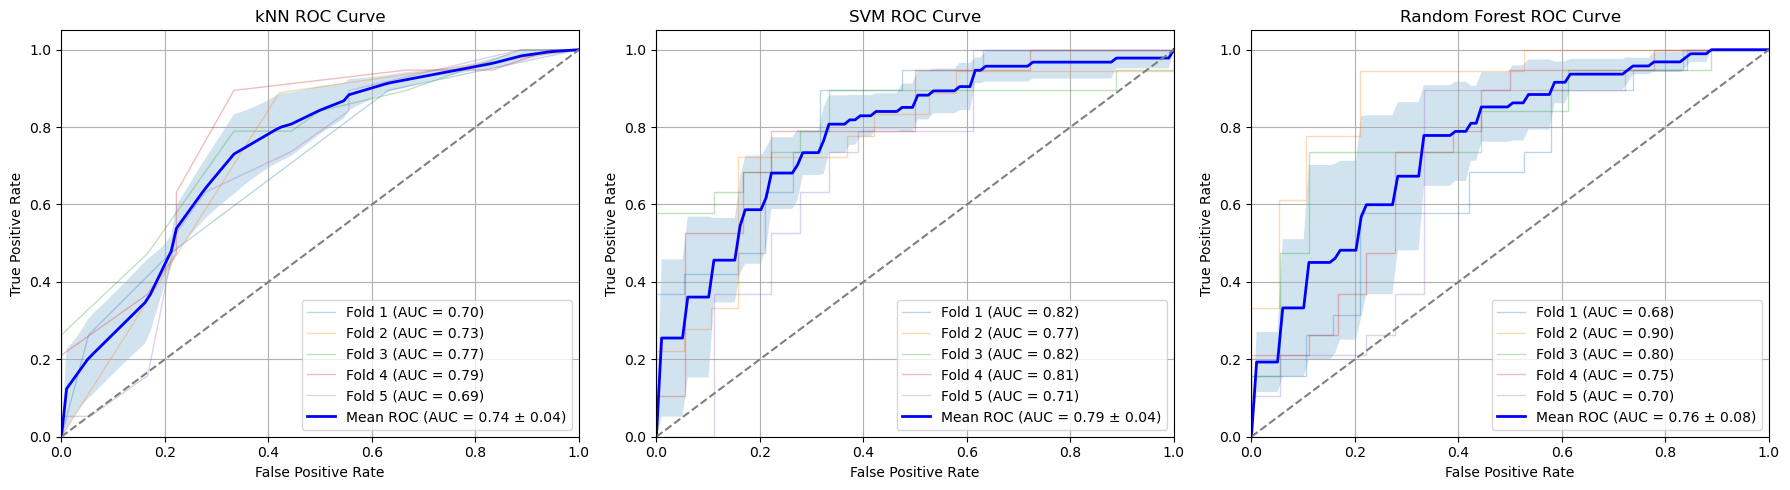

In [123]:
# Print the results for each complex classifier
for name in results_per_fold_complex:
    print(f"\n=== Results per fold for {name} ===")
    for fold_result in results_per_fold_complex[name]:
        # Print the results for each fold
        print(f"Fold {fold_result['fold']}:")
        print(f"Train Accuracy: {fold_result['train accuracy']:.4f}")
        print(f"Train ROC AUC: {fold_result['train ROC AUC']:.4f}")
        print(f"Test Accuracy: {fold_result['test accuracy']:.4f}")
        print(f"Test ROC AUC: {fold_result['test ROC AUC']:.4f}\n")
    
    train_accuracy_scores = [r['train accuracy'] for r in results_per_fold_complex[name]]
    train_auc_scores = [r['train ROC AUC'] for r in results_per_fold_complex[name]]
    accuracy_scores = [r['test accuracy'] for r in results_per_fold_complex[name]]
    roc_auc_scores = [r['test ROC AUC'] for r in results_per_fold_complex[name]]

    avg_train_accuracy = np.mean(train_accuracy_scores)
    std_train_accuracy = np.std(train_accuracy_scores)
    avg_train_auc = np.mean(train_auc_scores)
    std_train_auc = np.std(train_auc_scores)
    avg_test_accuracy = np.mean(accuracy_scores)
    std_test_accuracy = np.std(accuracy_scores)
    avg_test_auc = np.mean(roc_auc_scores)
    std_test_auc = np.std(roc_auc_scores)

    # Print the overall results for each complex classifier
    print(f"Overall Results for {name}:")
    print(f"Train Accuracy  (mean ± std): {avg_train_accuracy:.4f} ± {std_train_accuracy:.4f}")
    print(f"Train ROC AUC   (mean ± std): {avg_train_auc:.4f} ± {std_train_auc:.4f}")
    print(f"Test  Accuracy  (mean ± std): {avg_test_accuracy:.4f} ± {std_test_accuracy:.4f}")
    print(f"Test  ROC AUC   (mean ± std): {avg_test_auc:.4f} ± {std_test_auc:.4f}")

# Plot ROC curves for complex models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
mean_fpr = np.linspace(0, 1, 100)

# Loop through each complex model and plot ROC curves
for idx, (name, config) in enumerate(models_complex.items()):
    tprs = []
    aucs = []
    mean_tpr = np.zeros_like(mean_fpr)

    # Loop through each fold's results
    for fold_results in results_per_fold_complex[name]:
        fpr, tpr, _ = roc_curve(fold_results['y_true'], fold_results['y_pred_proba'])
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        fold_auc = auc(fpr, tpr)
        aucs.append(fold_auc)

        axes[idx].plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {fold_results["fold"]} (AUC = {fold_auc:.2f})')

    # Calculate mean and std of ROC curves
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    # Plot mean ROC curve
    axes[idx].plot(mean_fpr, mean_tpr, color='b',
                   label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    axes[idx].fill_between(mean_fpr,
                           np.maximum(mean_tpr - np.std(tprs, axis=0), 0),
                           np.minimum(mean_tpr + np.std(tprs, axis=0), 1), alpha=0.2)

    # Plot diagonal line
    axes[idx].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axes[idx].set_xlim([0.0, 1.0])
    axes[idx].set_ylim([0.0, 1.05])
    axes[idx].set_xlabel('False Positive Rate')
    axes[idx].set_ylabel('True Positive Rate')
    axes[idx].set_title(f'{name} ROC Curve')
    axes[idx].legend(loc='lower right')
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

## Learning curves best models
Using the most common hyperparameters from crossvalidation, the final models are refitted for kNN, SVM and RFC.

The learning curves (based on ROC AUC) are plotted to assess how model performance scales with more training data. These curves help identify overfitting.


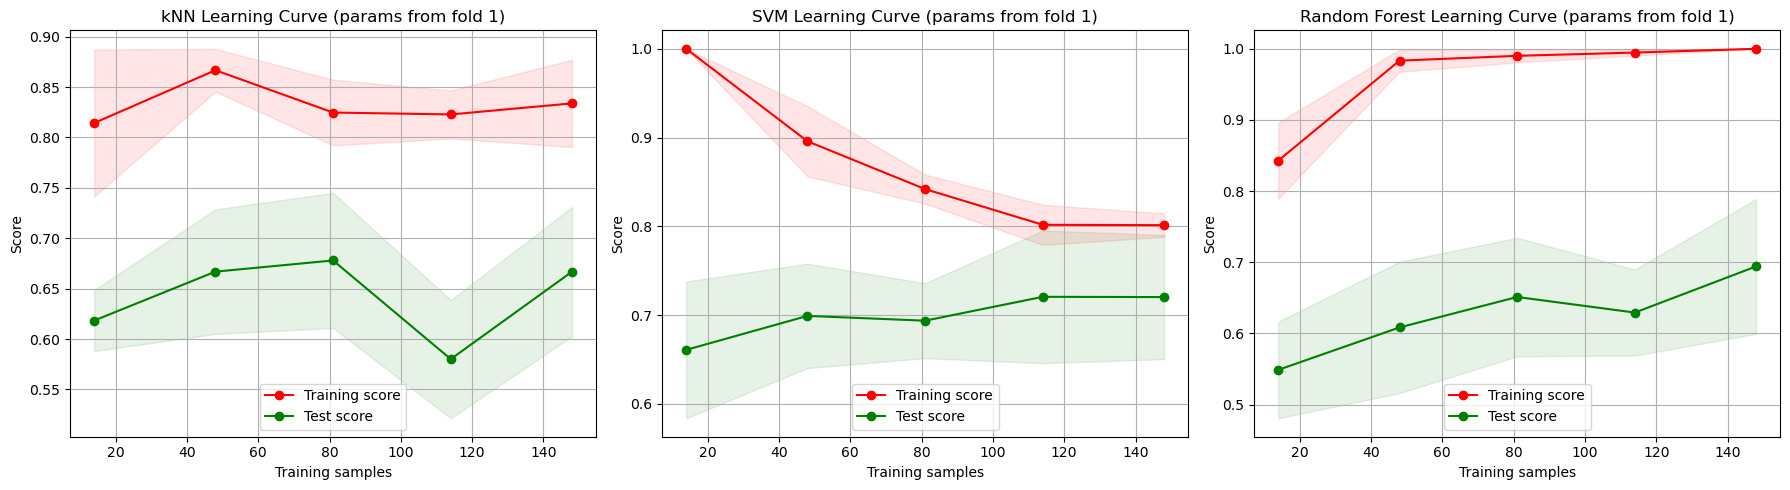

In [124]:
# Extract parameters from the first fold (fold 1) for each model
best_knn_params = models_complex["kNN"]["best_params"][0]
best_svm_params = models_complex["SVM"]["best_params"][0]
best_rf_params = models_complex["Random Forest"]["best_params"][0]

# Final pipelines with most common parameters
final_models = {
    "kNN": Pipeline([
        ('variance_filter', VarianceThreshold(threshold=0.05)),
        ('scaler', RobustScaler()),
        ('select', SelectKBest(score_func=f_classif, k=best_knn_params['select__k'])),
        ('clf', KNeighborsClassifier(
            n_neighbors=best_knn_params['clf__n_neighbors'],
            weights=best_knn_params['clf__weights'],
            p=best_knn_params['clf__p']
        ))
    ]),
    "SVM": Pipeline([
        ('variance_filter', VarianceThreshold(threshold=0.05)),
        ('scaler', RobustScaler()),
        ('select', SelectKBest(score_func=f_classif, k=best_svm_params['select__k'])),
        ('clf', SVC(
            C=best_svm_params['clf__C'],
            kernel=best_svm_params['clf__kernel'],
            gamma=best_svm_params['clf__gamma'],
            probability=True
        ))
    ]),
    "Random Forest": Pipeline([
        ('variance_filter', VarianceThreshold(threshold=0.05)),
        ('scaler', RobustScaler()),
        ('clf', RandomForestClassifier(
            n_estimators=best_rf_params['clf__n_estimators'],
            max_depth=best_rf_params['clf__max_depth'],
            min_samples_split=best_rf_params['clf__min_samples_split'],
            min_samples_leaf=best_rf_params['clf__min_samples_leaf'],
            max_features=best_rf_params['clf__max_features'],
            bootstrap=best_rf_params['clf__bootstrap'],
            min_impurity_decrease=best_rf_params['clf__min_impurity_decrease'],
            random_state=42
        ))
    ])
}

# Plot learning curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, model) in enumerate(final_models.items()):
    ax = axes[idx]
    ax.set_title(f"{name} Learning Curve (params from fold 1)")
    ax.set_xlabel("Training samples")
    ax.set_ylabel("Score")


    train_sizes, train_scores, test_scores = learning_curve(
        model, X_full, y_full, cv=outer_cv, scoring='accuracy',
        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")
    ax.legend(loc="lower center")

plt.tight_layout()
plt.show()
